['entity-73a9e3dd9d38966dbf7e752b485d9591'
 'entity-a3745716f642d1ebe3038fd59e0097ea']


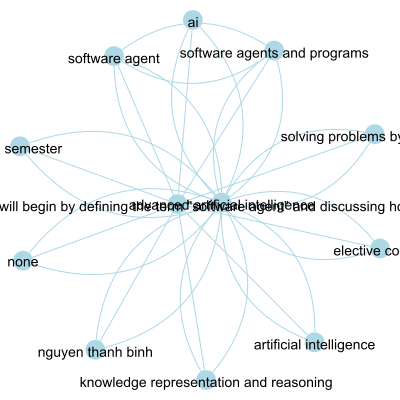

: 

In [17]:
import pickle
import os
import igraph as ig
import pandas as pd
from matplotlib import pyplot as plt
import json

tmpl_dirpath = "../outputs/main_evaluation/{major}_{kind_of_qa}_{postfix}"
majors = ["AM", "MCS", "DS"]
postfixes = ["hcmus_text-embedding-3-small"]
kinds_of_qa = ["closed_end"]

total_graph_info = []

for major in majors:
    for postfix in postfixes:
        for kind_of_qa in kinds_of_qa:
            dirpath = tmpl_dirpath.format(major=major, kind_of_qa=kind_of_qa, postfix=postfix)
            corpus_shared_path = os.path.join("../outputs/main_evaluation", f"{major}_corpus_shared")

            graph_fpath = os.path.join(corpus_shared_path, "llama3_8b_facebook_contriever", "graph.pickle")
            entity_fpath = os.path.join(corpus_shared_path, "llama3_8b_facebook_contriever", "entity_embeddings", "vdb_entity.parquet")
            chunk_fpath = os.path.join(corpus_shared_path, "llama3_8b_facebook_contriever", "chunk_embeddings", "vdb_chunk.parquet")

            results_fpath = os.path.join("../outputs/main_evaluation", f"{major}_{kind_of_qa}_results", f"{major}_{kind_of_qa}_results.json")

            if not (os.path.exists(graph_fpath) and os.path.exists(entity_fpath) and os.path.exists(chunk_fpath) and os.path.exists(results_fpath)):
                print(f"Missing file(s) for {major} - skipping...")
                continue

            graph_info = json.load(open(results_fpath, "r", encoding='utf-8')).get("system_stats", {})
            graph = pickle.load(open(graph_fpath, "rb"))
            entity_embeddings = pd.read_parquet(entity_fpath)
            chunk_embeddings = pd.read_parquet(chunk_fpath)

            total_graph_info.append({f"{major}": graph_info})

            if "type" not in graph.vs.attributes():
                graph.vs["type"] = ["unknown"] * len(graph.vs)

            vertex_colors = []
            for vertex in graph.vs:
                hash_id = vertex["hash_id"] if "hash_id" in vertex.attributes() else ""
                if hash_id.startswith('chunk-'):
                    vertex_colors.append('red')
                elif hash_id.startswith('entity-'):
                    vertex_colors.append('lightblue')
                else:
                    vertex_colors.append('lightblue')

            layout = graph.layout("fr")
            layout.scale(10)
            ig.plot(
                graph,
                vertex_size=5,
                vertex_color=vertex_colors,
                edge_color='gray', edge_width=0.3,
                vertex_frame_width=0.2,
                bbox=(400, 400), margin=20, layout=layout, target=f'../results/graph_{major}_Llama-3.1-8B.pdf'
            )

rows = []
for d in total_graph_info:
    for major, metrics in d.items():
        for metric, value in metrics.items():
            rows.append({'major': major, 'metric': metric, 'value': value})

df = pd.DataFrame(rows)
df

selected_contents = [
    "advanced artificial intelligence",
    "nguyen thanh binh",
    "advanced research topics in data mining"
]

selected_hash_id = entity_embeddings[entity_embeddings["content"].isin(selected_contents)]["hash_id"].values
print(selected_hash_id)

selected_index = graph.vs.find(name=selected_hash_id[0]).index
neighbor_indices = graph.neighborhood(selected_index, order=1)
subgraph = graph.induced_subgraph(neighbor_indices)

subgraph.vs["content"] = [graph.vs[i]["content"] for i in neighbor_indices]
subgraph.vs["name"] = [graph.vs[i]["name"] for i in neighbor_indices]
subgraph.vs["type"] = [graph.vs[i]["type"] for i in neighbor_indices]
labels = [item.split("\n")[0] for item in subgraph.vs["content"]]

color_map = {"chunk": "red", "entity": "lightblue"}
subgraph.vs["color"] = [color_map.get(t, "lightblue") for t in subgraph.vs["type"]]

layout_sub = subgraph.layout("kk")  # thử "kk" hoặc thay bằng "drl"
layout_sub = subgraph.layout("kk")
layout_sub.scale(1.5)
ig.plot(
    subgraph,
    vertex_label=labels,
    edge_label=subgraph.es["label"] if "label" in subgraph.es.attributes() else None,
    bbox=(400, 400), margin=20, layout=layout_sub, target='../results/vis_graph_selected_node_Llama-3.1-8B.pdf',
    vertex_color=subgraph.vs["color"],
    edge_color='lightblue',
    vertex_frame_color='white', vertex_frame_width=0.2
)
